In [1]:
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt2

import os
from datetime import date, timedelta, datetime

Using TensorFlow backend.


In [2]:
_code_ = 50
_window_ = 30 # days
_train_test_split_ = 0.9

_scaler_ = prep.MinMaxScaler() # StandardScaler()

_loss_ = "mean_squared_error"
_optimizer_ = "adam" # rmsprop
_batch_size_ = 768
_epochs_ = 100
_validation_split_ = 0.0

_date_ = '20180518'

In [3]:
def build_model(layers):
    model = Sequential()
    
#     model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))
#     model.add(Dropout(0.4))
#     model.add(LSTM(100, input_shape=(None, layers[1]), return_sequences=False))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation="linear"))

    model.add(LSTM(20, input_shape=(None, layers[0]), return_sequences=True))
    model.add(LSTM(50, input_shape=(None, layers[1]), return_sequences=False))
    model.add(Dense(1, activation="linear"))

#     model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))
#     model.add(LSTM(100, input_shape=(None, layers[1]), return_sequences=True))
#     model.add(LSTM(50, input_shape=(None, layers[1]), return_sequences=False))
#     model.add(Dense(1, activation="linear"))
    
    model.compile(loss=_loss_, optimizer=_optimizer_, metrics=['accuracy'])

    return model

In [4]:
def scale_data(X):
    samples, nx, ny = X.shape
    X = X.reshape((samples, nx * ny))
    
    scaler = _scaler_.fit(X)
    X = scaler.transform(X)
    
    return X.reshape((samples, nx, ny))

In [5]:
def scale_backward(d, y):
    if type(_scaler_) is prep.data.MinMaxScaler:
        return y * (max(d) - min(d)) + min(d)

In [6]:
def scale_toward(d, x):
    if type(_scaler_) is prep.data.MinMaxScaler:
        return (x - min(d)) / (max(d) - min(d))

In [7]:
def preprocess_data(data, _column_):
    feature_len = len(data.columns)
    data = data.as_matrix()
    
    """
    e.g., _window_ = 3
    0~3 1~4 2~5  result
    0~2 1~3 2~4  X
    3   4   5    y
    """
    seq_len = _window_ + 1  ## _window_s + 1
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index : index + seq_len])
        
    result = np.array(result)
    scaled_result = scale_data(result)
    
    row = round(_train_test_split_ * scaled_result.shape[0])
    train, test = scaled_result[:int(row)], scaled_result[int(row):]

    X_train = train[:, :-1, :]
    y_train = train[:, -1, :][:, _column_]  ## change
    
    X_test = test[:, :-1, :]
    y_test = test[:, -1, :][:, _column_]  ## change

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feature_len))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], feature_len))

    return [X_train, y_train, X_test, y_test]

In [8]:
def plot_result(pred, y):
    plt2.figure()
    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y, color='blue', label='Ground Truth')
    plt2.legend()
    plt2.show()

In [9]:
# ↓↓↓ __main__

In [10]:
df = pd.read_csv('/home/ddl/Desktop/Notebooks/TBrain/' + _date_ + '/taetfp.csv', thousands=',')

data = df[df['代碼'] == _code_].sort_values(by='日期', ascending=False) \
                                    .drop(columns=['日期', '中文簡稱'])

In [11]:
X_train, y_train, X_test, y_test = preprocess_data(data, -1)
X_train.shape, y_train.shape

((1157, 30, 6), (1157,))

成交張數 Test Score: 0.01 MSE (0.11 RMSE)


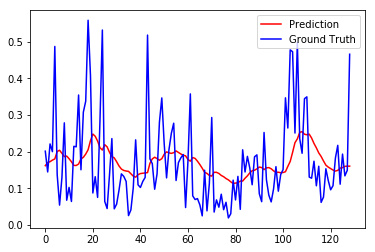

In [12]:
# number of transactions
X_train, y_train, X_test, y_test = preprocess_data(data, -1)

model_num = build_model([X_train.shape[2], _window_])
model_num.fit(X_train, y_train, batch_size=_batch_size_, epochs=_epochs_, validation_split=_validation_split_, verbose=0)

if _train_test_split_ != 1.0:
    testScore = model_num.evaluate(X_test, y_test, verbose=0)
    print('成交張數 Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    plot_result(model_num.predict(X_test), y_test)

收盤價 Test Score: 0.00 MSE (0.03 RMSE)


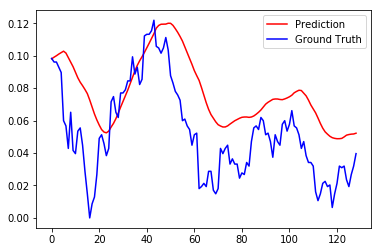

In [13]:
# close price
X_train, y_train, X_test, y_test = preprocess_data(data, -2)

model_close = build_model([X_train.shape[2], _window_])
model_close.fit(X_train, y_train, batch_size=_batch_size_, epochs=_epochs_, validation_split=_validation_split_, verbose=0)

if _train_test_split_ != 1.0:
    testScore = model_close.evaluate(X_test, y_test, verbose=0)
    print('收盤價 Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    plot_result(model_close.predict(X_test), y_test)

In [14]:
# low price
X_train, y_train, X_test, y_test = preprocess_data(data, -3)

model_low = build_model([X_train.shape[2], _window_])
model_low.fit(X_train, y_train, batch_size=_batch_size_, epochs=_epochs_, validation_split=_validation_split_, verbose=0)

if _train_test_split_ != 1.0:
    testScore = model_low.evaluate(X_test, y_test, verbose=0)
    print('最低價 Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    plot_result(model_low.predict(X_test), y_test)

KeyboardInterrupt: 

In [ ]:
# high price
X_train, y_train, X_test, y_test = preprocess_data(data, -4)

model_high = build_model([X_train.shape[2], _window_])
model_high.fit(X_train, y_train, batch_size=_batch_size_, epochs=_epochs_, validation_split=_validation_split_, verbose=0)

if _train_test_split_ != 1.0:
    testScore = model_high.evaluate(X_test, y_test, verbose=0)
    print('最高價 Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    plot_result(model_high.predict(X_test), y_test)

In [ ]:
# open price
X_train, y_train, X_test, y_test = preprocess_data(data, -5)

model_open = build_model([X_train.shape[2], _window_])
model_open.fit(X_train, y_train, batch_size=_batch_size_, epochs=_epochs_, validation_split=_validation_split_, verbose=0)

if _train_test_split_ != 1.0:
    testScore = model_open.evaluate(X_test, y_test, verbose=0)
    print('開盤價 Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    plot_result(model_open.predict(X_test), y_test)

In [ ]:
# predict 5 days

o1, o2, o3, o4, o5 = [], [], [], [], []
pred = []

for i in range(0, 5):
    dataArr = np.array(data)
    
    if i == 0:
        X = dataArr[:_window_]
    else:
        X = np.append(pred[::-1], dataArr[:_window_-i], axis=0)
    
    X[:, 0] = 0
    X[:, 1] = scale_toward(list(dataArr[:, 1]) + o1, X[:, 1])
    X[:, 2] = scale_toward(list(dataArr[:, 2]) + o2, X[:, 2])
    X[:, 3] = scale_toward(list(dataArr[:, 3]) + o3, X[:, 3])
    X[:, 4] = scale_toward(list(dataArr[:, 4]) + o4, X[:, 4])
    X[:, 5] = scale_toward(list(dataArr[:, 5]) + o5, X[:, 5])
    
    X = np.expand_dims(X, axis=0)
    
    p = [
        0,
        scale_backward(list(dataArr[:, 1]) + o1, model_open.predict(X)),
        scale_backward(list(dataArr[:, 2]) + o2, model_high.predict(X)),
        scale_backward(list(dataArr[:, 3]) + o3, model_low.predict(X)),
        scale_backward(list(dataArr[:, 4]) + o4, model_close.predict(X)),
        scale_backward(list(dataArr[:, 5]) + o5, model_num.predict(X))
    ]
    
    p = [float(j) for j in p]
    
    o1 += [p[1]]
    o2 += [p[2]]
    o3 += [p[3]]
    o4 += [p[4]]
    o5 += [p[5]]
    pred.append(p)

In [ ]:
model_open.predict(X).shape

In [ ]:
# print result
def show_msg(now, last):
    diff = float( format(now, '.2f') ) - float( format(last, '.2f') )
    if diff > 0:
        return "1"  # 漲
    elif diff < 0:
        return "-1" # 跌
    else:
        return "0"

def format_n_days(price):
    output = str(_code_) + '\t'
    for i in range(0, 5 if len(price)>=5 else len(price)):
        if i==0:
            output += '{}\t{:.2f}\t'.format(show_msg(price[i], last), price[i])
        else:
            output += '{}\t{:.2f}\t'.format(show_msg(price[i], price[i-1]), price[i])
    return output

def TBrain_score(predict_str, real_str):
    predict = predict_str.split('\t')[1:-1]
    real = real_str.split('\t')[1:-1]

    weights = [0.10, 0.15, 0.20, 0.25, 0.30]

    # (實際價格 – 絕對值(預測價格 – 實際價格)) /實際價格)*0.5
    p_score = [
        ( ( float(r) - abs(float(r) - float(p)) ) / float(r) ) * 0.5
        for (r, p) in zip(real[1::2], predict[1::2]) 
    ]

    # 預測正確得 0.5
    q_score = [
        0.5 if float(r) == float(p) else 0.0
        for (r, p) in zip(real[0::2], predict[0::2])
    ]

    return sum([ p*w + q*w for (p, q, w) in zip(p_score, q_score, weights) ])


# print predict
last = np.array(data)[0][-2]
date = int(df[df['代碼'] == _code_].sort_values(by='日期', ascending=False).head(1).日期)
print(format_n_days(o4))

# print real
real_date = (datetime.strptime(_date_, '%Y%m%d')  + timedelta(days=7)).strftime('%Y%m%d')
real_path = '/home/ddl/Desktop/Notebooks/TBrain/' + real_date + '/taetfp.csv'
if os.path.exists(real_path):
    df2 = pd.read_csv(real_path, thousands=',')
    df2 = df2[df2['代碼'] == _code_]
    df2 = list( df2[df2['日期'] > date]['收盤價(元)'] )
    print(format_n_days(df2) + '(real)')
    print(TBrain_score(format_n_days(o4), format_n_days(df2)))